# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import h5py
from os.path import basename
import re
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

# full scans

In [2]:
folder = '../data/4-4-2024/'
files = sorted(glob(folder+'temperature*'))
files

['../data/4-4-2024\\temperature__scan_cooling_250k-150k_5imgs_0.h5',
 '../data/4-4-2024\\temperature_scan_heating_150K-250K_5imgs_a329de9b-f643-4d3e-b267-ab723f3b1dfb.h5',
 '../data/4-4-2024\\temperature_scan_heating_150k-250k_0.h5']

## heating 0

In [3]:
file = files[1]
with h5py.File(file, 'r') as f:
    img = f['entry1']['instrument_1']['detector_1']['data'][0]

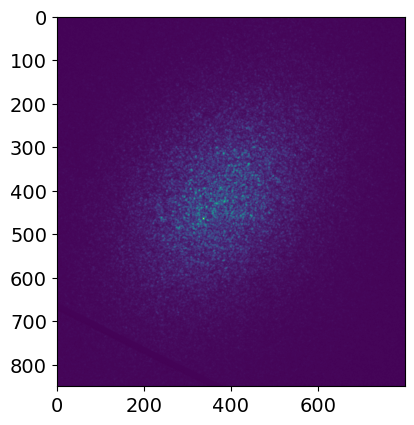

In [10]:
roi = np.s_[150:1000, 1100:1900]

plt.imshow(img[0][roi])

In [14]:
file = files[1]
with h5py.File(file, 'r') as f:
    heating0 = f['entry1']['instrument_1']['detector_1']['data'][(..., -1, *roi)]
    temps_heating0 = f['entry1']['instrument_1']['labview_data']['LS_LLHTA'][:]

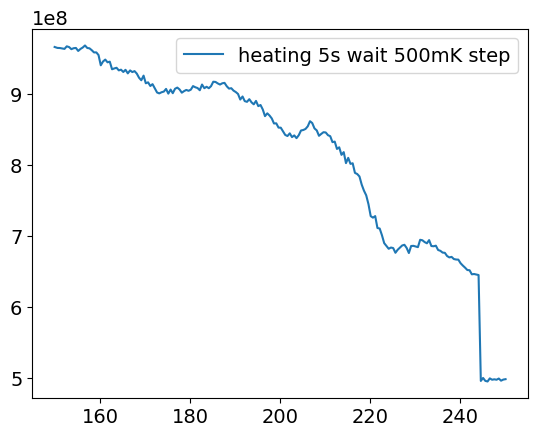

In [17]:
h0 = np.sum(heating0, axis=(1,2))

plt.figure()
plt.plot(temps_heating0, h0, label='heating 5s wait 500mK step')
plt.legend()
plt.show()

## cooling 0

In [25]:
file = files[0]
with h5py.File(file, 'r') as f:
    print(f['entry']['data']['data'].shape)
    cooling0 = f['entry']['data']['data'][(..., *roi)]

(1004, 2048, 2048)


In [27]:
c0 = cooling0[::5].sum(axis=(1,2))

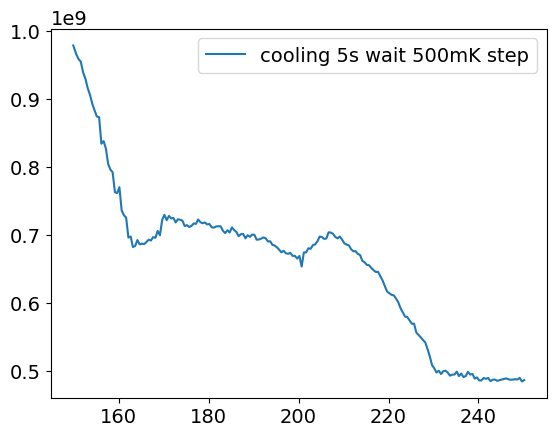

In [28]:
plt.figure()
plt.plot(temps_heating0[::-1], c0, label='cooling 5s wait 500mK step')
plt.legend()
plt.show()

## heating 1

In [29]:
file = files[2]
with h5py.File(file, 'r') as f:
    heating1 = f['entry']['data']['data'][(..., *roi)]

In [30]:
h1 = heating1[::5].sum(axis=(1,2))

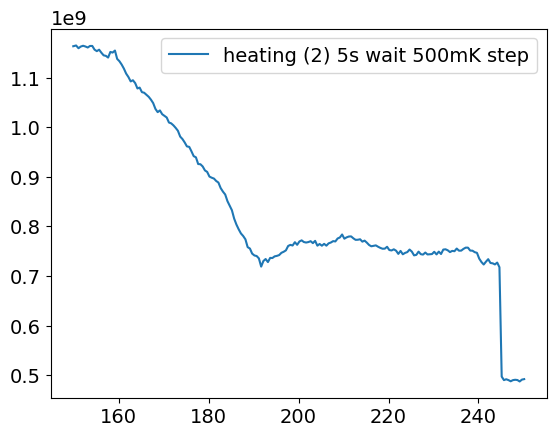

In [31]:
plt.figure()
plt.plot(temps_heating0, h1, label='heating (2) 5s wait 500mK step')
plt.legend()
plt.show()

## combined

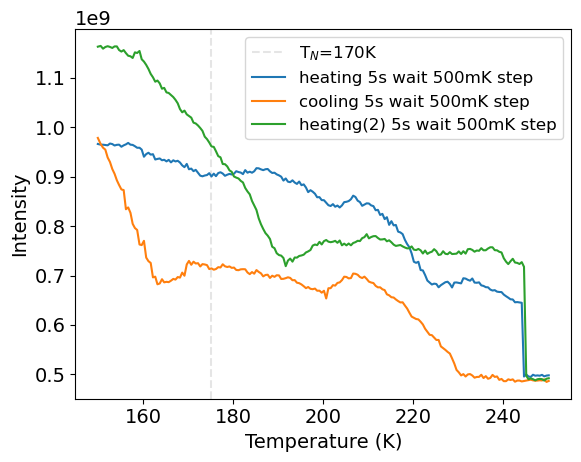

In [47]:
plt.figure()
plt.axvline(175, color='k', linestyle='--', alpha=0.1, label=r'T$_N$=170K')
plt.plot(temps_heating0, h0, label='heating 5s wait 500mK step')
plt.plot(temps_heating0[::-1], c0, label='cooling 5s wait 500mK step')
plt.plot(temps_heating0, h1, label='heating(2) 5s wait 500mK step')
plt.legend(fontsize=12)
plt.ylabel('Intensity')
plt.xlabel('Temperature (K)')
plt.show()

In [49]:
df = {'heating_0': {'intensity': h0, 'temperature': temps_heating0},
      'heating_1': {'intensity': h1, 'temperature': temps_heating0},
       'cooling_0': {'intensity': c0, 'temperature': temps_heating0[::-1]} }
df = pd.DataFrame(df)

In [50]:
df.head()

,heating_0,heating_1,cooling_0
intensity,"[966284261, 964941788, 964819365, 964288906, 9...","[1163242427, 1164784824, 1159245255, 116261689...","[486642479, 484608218, 489921494, 487504730, 4..."
temperature,"[149.89000000000001, 150.52, 151.05, 151.56, 1...","[149.89000000000001, 150.52, 151.05, 151.56, 1...","[250.17000000000002, 249.67000000000002, 249.1..."


In [51]:
df.to_csv('../data/4-4-2024/temperature_scans_df.csv')

# pre xpcs

In [2]:
folder = '../data/4-4-2024/'
files = sorted(glob(folder+'heating*'))
files

['../data/4-4-2024\\heating1_0.h5',
 '../data/4-4-2024\\heating2_0.h5',
 '../data/4-4-2024\\heating3_0.h5',
 '../data/4-4-2024\\heating3_take2_0.h5',
 '../data/4-4-2024\\heating4_0.h5',
 '../data/4-4-2024\\heating5_0.h5']

In [3]:
file = files[0]
with h5py.File(file, 'r') as f:
    print(f['entry']['data']['data'].shape)

(120, 2048, 2048)


In [4]:
roi = np.s_[150:1000, 1100:1900]
for i, file in tqdm(enumerate(files), total=len(files)):
    with h5py.File(file, 'r') as f:
        globals()[f'h{i}'] = f['entry']['data']['data'][(..., *roi)]
        bkgd = np.mean(globals()[f'h{i}'][:, :, -50:], axis=(0, -1))
        globals()[f'h{i}'] = globals()[f'h{i}'].astype(float) - np.expand_dims(bkgd, axis=1)
        globals()[f'h{i}'] = globals()[f'h{i}'][::20]
        globals()[f'h{i}'][globals()[f'h{i}']<0] = 0

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
folder = '../data/4-4-2024/'
files = sorted(glob(folder+'cooling*'))
files = [files[-1], *files[:-1]]
files

['../data/4-4-2024\\cooling_0.h5',
 '../data/4-4-2024\\cooling1_0.h5',
 '../data/4-4-2024\\cooling2_0.h5',
 '../data/4-4-2024\\cooling3_0.h5',
 '../data/4-4-2024\\cooling3_take2_0.h5',
 '../data/4-4-2024\\cooling4_0.h5']

In [6]:
for i, file in tqdm(enumerate(files), total=len(files)):
    with h5py.File(file, 'r') as f:
        globals()[f'c{i}'] = f['entry']['data']['data'][(..., *roi)]
        bkgd = np.mean(globals()[f'c{i}'][:, :, -50:], axis=(0, -1))
        globals()[f'c{i}'] = globals()[f'c{i}'].astype(float) - np.expand_dims(bkgd, axis=1)
        globals()[f'c{i}'][globals()[f'c{i}']<0] = 0

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
sc0 = c0[::40]
sc1 = c1[::40]
sc2 = c2[::40]
sc3 = c3[::20]
sc4 = c4[::20]
sc5 = c5[::20]

In [12]:
th0 = np.linspace(245, 250, len(h0))
th1 = np.linspace(235, 250, len(h1))
th2 = np.linspace(230, 250, len(h2))
th3 = np.linspace(225, 250, len(h3))
th4 = np.linspace(225, 250, len(h4)) # mostly darks, shutter didn't open
th5 = np.linspace(220, 238, len(h5))

for i in range(len(files)):
    globals()[f'tc{i}'] = globals()[f'th{i}'][::-1]

tc0 = np.linspace(250, 245, len(sc0))
tc1 = np.linspace(250, 235, len(sc1))
tc5 = np.linspace(250, 220, len(sc5))

Text(0.5, 1.0, 'heating')

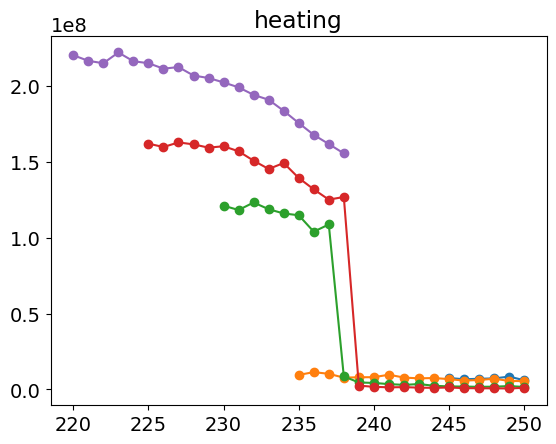

In [13]:
plt.plot(th0, h0.sum(axis=(1,2)), '-o')
plt.plot(th1, h1.sum(axis=(1,2)), '-o')
plt.plot(th2, h2.sum(axis=(1,2)), '-o')
plt.plot(th3, h3.sum(axis=(1,2)), '-o')
#plt.plot(th4, h4.sum(axis=(1,2)), '-o')
plt.plot(th5, h5.sum(axis=(1,2)), '-o')
plt.title('heating')

Text(0.5, 1.0, 'cooling')

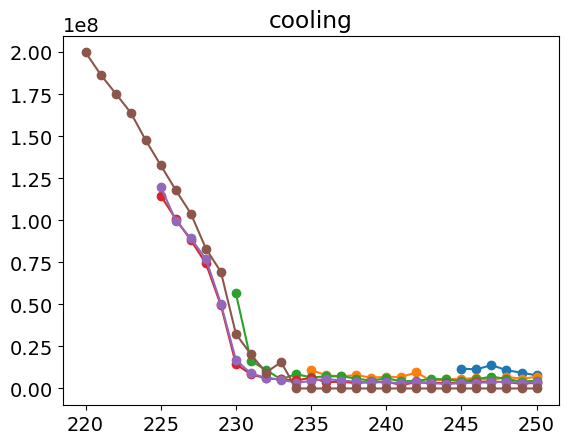

In [14]:
plt.plot(tc0, sc0.sum(axis=(1,2)), '-o')
plt.plot(tc1, sc1.sum(axis=(1,2)), '-o')
plt.plot(tc2, sc2.sum(axis=(1,2)), '-o')
plt.plot(tc3, sc3.sum(axis=(1,2)), '-o')
plt.plot(tc4, sc4.sum(axis=(1,2)), '-o')
plt.plot(tc5, sc5.sum(axis=(1,2)), '-o')
plt.title('cooling')

In [19]:
temps_cycle0 = np.ravel([tc0, th0])
cycle0 = np.ravel([sc0.sum(axis=(1,2)), h0.sum(axis=(1,2))])

temps_cycle1 = np.ravel([tc1, th1])
cycle1 = np.ravel([sc1.sum(axis=(1,2)), h1.sum(axis=(1,2))])

temps_cycle2 = np.ravel([tc2, th2])
cycle2 = np.ravel([sc2.sum(axis=(1,2)), h2.sum(axis=(1,2))])

temps_cycle3 = np.ravel([tc3, th3])
cycle3 = np.ravel([sc3.sum(axis=(1,2)), h3.sum(axis=(1,2))])

temps_cycle4 = np.ravel([tc4, th4])
cycle4 = np.ravel([sc4.sum(axis=(1,2)), h4.sum(axis=(1,2))])

temps_cycle5 = np.ravel(np.append(tc5, th5))
cycle5 = np.ravel(np.append(sc5.sum(axis=(1,2)), h5.sum(axis=(1,2))))


Text(0.5, 0, 'Temperature (K)')

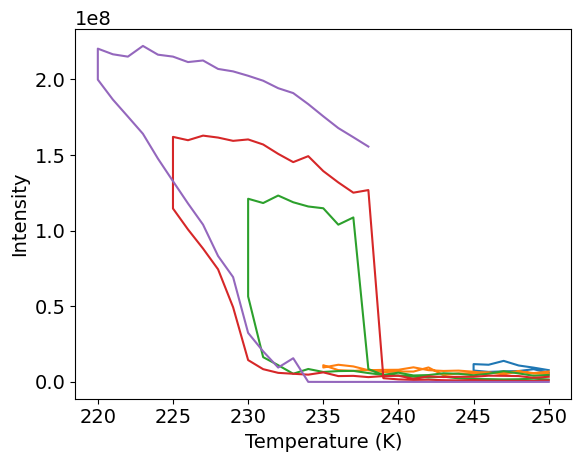

In [20]:
plt.plot(temps_cycle0, cycle0)
plt.plot(temps_cycle1, cycle1)
plt.plot(temps_cycle2, cycle2)
plt.plot(temps_cycle3, cycle3)
#plt.plot(temps_cycle4, cycle4)
plt.plot(temps_cycle5, cycle5)
plt.ylabel('Intensity')
plt.xlabel('Temperature (K)')

Text(0.5, 0, 'Temperature (K)')

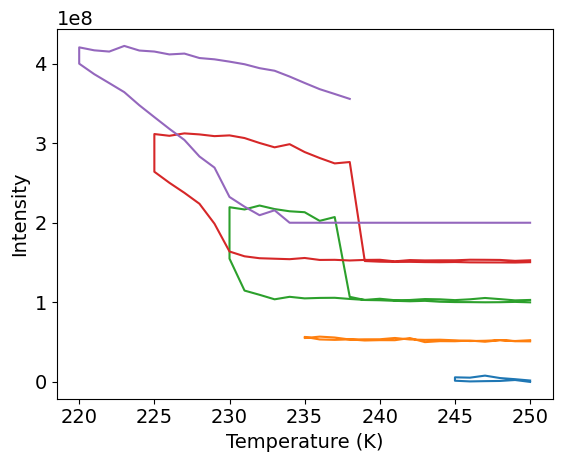

In [21]:
offset = 5e7
plt.plot(temps_cycle0, cycle0-min(cycle0))
plt.plot(temps_cycle1, cycle1-min(cycle1)+offset)
plt.plot(temps_cycle2, cycle2-min(cycle2)+2*offset)
plt.plot(temps_cycle3, cycle3-min(cycle3)+3*offset)
#plt.plot(temps_cycle4, cycle4-min(cycle4))
plt.plot(temps_cycle5, cycle5-min(cycle5)+4*offset)
plt.ylabel('Intensity')
plt.xlabel('Temperature (K)')


In [22]:
df = {'cycle0': {'temperature': temps_cycle0, 'intensity': cycle0},
      'cycle1': {'temperature': temps_cycle1, 'intensity': cycle1},
      'cycle2': {'temperature': temps_cycle2, 'intensity': cycle2},
      'cycle3': {'temperature': temps_cycle3, 'intensity': cycle3},
      'cycle4': {'temperature': temps_cycle4, 'intensity': cycle4},
      'cycle5': {'temperature': temps_cycle5, 'intensity': cycle5}}

df = pd.DataFrame(df)

In [23]:
df.head()

,cycle0,cycle1,cycle2,cycle3,cycle4,cycle5
temperature,"[250.0, 249.0, 248.0, 247.0, 246.0, 245.0, 245...","[250.0, 249.0, 248.0, 247.0, 246.0, 245.0, 244...","[250.0, 249.0, 248.0, 247.0, 246.0, 245.0, 244...","[250.0, 249.0, 248.0, 247.0, 246.0, 245.0, 244...","[250.0, 249.0, 248.0, 247.0, 246.0, 245.0, 244...","[250.0, 249.0, 248.0, 247.0, 246.0, 245.0, 244..."
intensity,"[7785912.431904767, 9441079.604095241, 1086819...","[6856395.910687499, 5844849.86796875, 6892310....","[4609382.18307143, 4073505.8762380946, 5641695...","[3425615.5505384626, 2719362.5364615386, 38741...","[3791005.351038463, 3240702.7874615383, 414817...","[16998.958483870963, 4017.562225806449, 5907.8..."


In [24]:
df.to_csv('../data/4-4-2024/temperature_loops_df.csv')

In [34]:
from scipy.ndimage import gaussian_filter1d

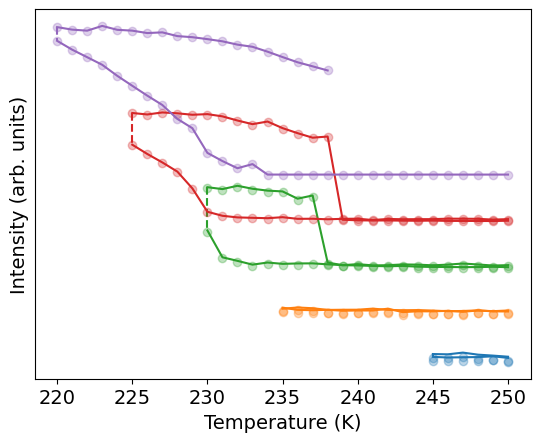

In [89]:
offset = 7e7
plt.plot(temps_cycle0, cycle0-min(cycle0), 'C0o', alpha=0.3)
plt.plot(tc0, sc0.sum(axis=(1,2)), 'C0')
plt.plot(th0, h0.sum(axis=(1,2)), 'C0')
plt.vlines(th0[0], ymin=(h0.sum(axis=(1,2)))[0],
            ymax=(sc0.sum(axis=(1,2)))[-1], color='C0', linestyle='--')

plt.plot(temps_cycle1, cycle1-min(cycle1)+offset, 'C1o', alpha=0.3)
plt.plot(tc1, sc1.sum(axis=(1,2)) + offset, 'C1')
plt.plot(th1, h1.sum(axis=(1,2)) + offset, 'C1')
plt.vlines(th1[0], ymin=(h1.sum(axis=(1,2)) + offset)[0],
            ymax=(sc1.sum(axis=(1,2)) + offset)[-1], color='C1', linestyle='--')

plt.plot(temps_cycle2, cycle2-min(cycle2)+2*offset, 'C2o', alpha=0.3)
plt.plot(tc2, sc2.sum(axis=(1,2)) + 2*offset, 'C2')
plt.plot(th2, h2.sum(axis=(1,2)) + 2*offset, 'C2')
plt.vlines(th2[0], ymin=(h2.sum(axis=(1,2)) + 2*offset)[0],
            ymax=(sc2.sum(axis=(1,2)) + 2*offset)[-1], color='C2', linestyle='--')

plt.plot(temps_cycle3, cycle3-min(cycle3)+3*offset, 'C3o', alpha=0.3)
plt.plot(tc3, sc3.sum(axis=(1,2)) + 3*offset, 'C3')
plt.plot(th3, h3.sum(axis=(1,2)) + 3*offset, 'C3')
plt.vlines(th3[0], ymin=(h3.sum(axis=(1,2)) + 3*offset)[0],
            ymax=(sc3.sum(axis=(1,2)) + 3*offset)[-1], color='C3', linestyle='--')

plt.plot(temps_cycle5, cycle5-min(cycle5)+4*offset, 'C4o', alpha=0.3)
plt.plot(tc5, sc5.sum(axis=(1,2)) + 4*offset, 'C4')
plt.plot(th5, h5.sum(axis=(1,2)) + 4*offset, 'C4')
plt.vlines(th5[0], ymin=(h5.sum(axis=(1,2)) + 4*offset)[0],
            ymax=(sc5.sum(axis=(1,2)) + 4*offset)[-1], color='C4', linestyle='--')

plt.ylabel('Intensity (arb. units)')
plt.xlabel('Temperature (K)')
plt.yticks([])

plt.show()

In [197]:
tmp = []
for i in range(len(files)):
    tmp.append(globals()[f'h{i}'].sum(axis=(1,2))[0].astype('float') - globals()[f'sc{i}'].sum(axis=(1,2))[-1].astype('float'))

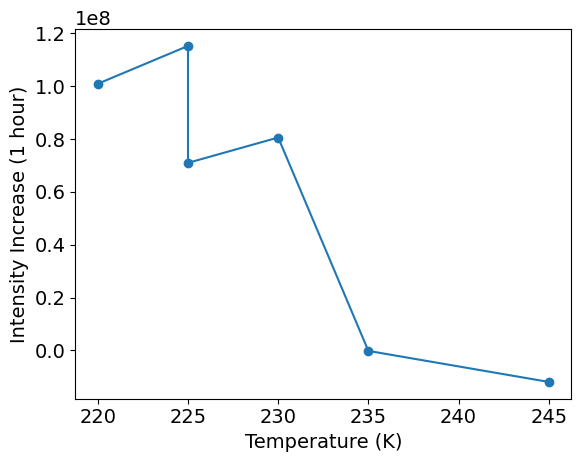

In [200]:
plt.ylabel('Intensity Increase (1 hour)')
plt.xlabel('Temperature (K)')
plt.plot([245, 235, 230, 225, 225, 220], tmp, '-o')